In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [10]:
# 1. Tiền xử lý dữ liệu
# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/GOOG.csv')


In [12]:
# Kiểm tra giá trị thiếu
print("Kiểm tra giá trị thiếu:")
print(data.isnull().sum())
# Xử lý giá trị thiếu bằng nội suy tuyến tính
data['Close'] = data['Close'].interpolate(method='linear')
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.set_index('Date', inplace=True)
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
data = data.dropna()

Kiểm tra giá trị thiếu:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [13]:
# Kiểm tra outliers bằng IQR
close_prices = data['Close']
Q1 = close_prices.quantile(0.25)
Q3 = close_prices.quantile(0.75)
IQR = Q3 - Q1
outliers = close_prices[(close_prices < (Q1 - 1.5 * IQR)) | (close_prices > (Q3 + 1.5 * IQR))]
print(f"Số lượng outliers: {len(outliers)}")

Số lượng outliers: 319


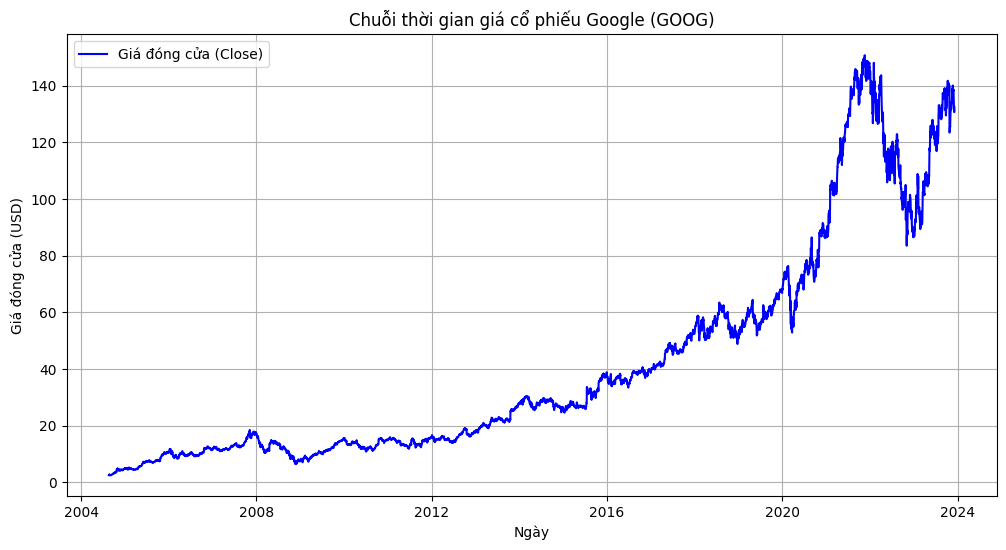

In [14]:
# 2. Vẽ đồ thị chuỗi thời gian
plt.figure(figsize=(12, 6))
plt.plot(close_prices, label='Giá đóng cửa (Close)', color='blue')
plt.title('Chuỗi thời gian giá cổ phiếu Google (GOOG)')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# 3. Kiểm tra tính dừng bằng kiểm định ADF
def adf_test(series, title=''):
    print(f'Kiểm định ADF cho {title}:')
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Kết luận:')
    if result[1] <= 0.05:
        print('Chuỗi dừng (stationary) - bác bỏ giả thuyết không dừng.')
    else:
        print('Chuỗi không dừng (non-stationary) - không bác bỏ giả thuyết không dừng.')
    print()

adf_test(close_prices, 'Chuỗi giá đóng cửa gốc')

Kiểm định ADF cho Chuỗi giá đóng cửa gốc:
ADF Statistic: 0.8367
p-value: 0.9922
Kết luận:
Chuỗi không dừng (non-stationary) - không bác bỏ giả thuyết không dừng.



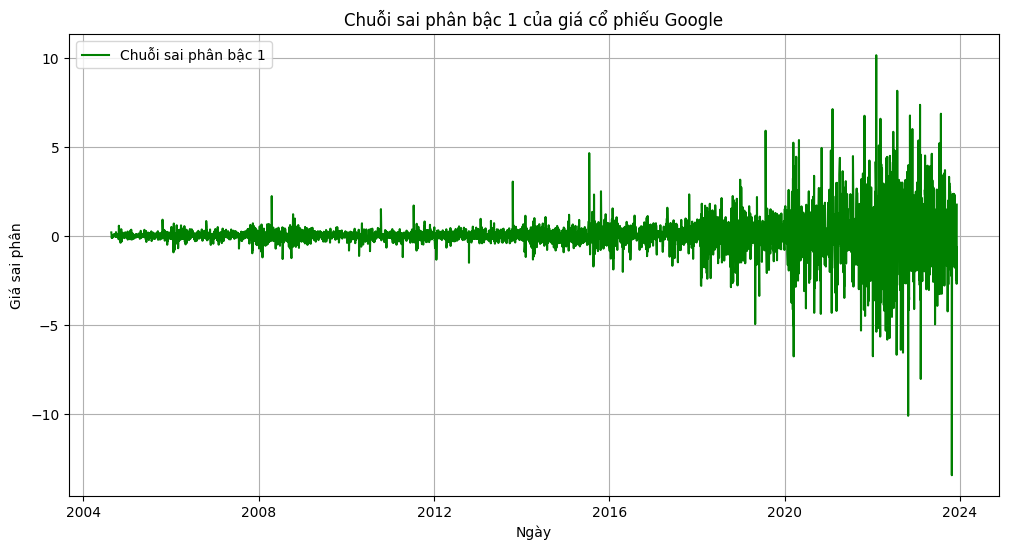

Kiểm định ADF cho Chuỗi sai phân bậc 1:
ADF Statistic: -13.1546
p-value: 0.0000
Kết luận:
Chuỗi dừng (stationary) - bác bỏ giả thuyết không dừng.



In [20]:
# 4. Sai phân bậc 1 để đạt tính dừng
diff_close = close_prices.diff().dropna()

# Vẽ đồ thị chuỗi sai phân
plt.figure(figsize=(12, 6))
plt.plot(diff_close, label='Chuỗi sai phân bậc 1', color='green')
plt.title('Chuỗi sai phân bậc 1 của giá cổ phiếu Google')
plt.xlabel('Ngày')
plt.ylabel('Giá sai phân')
plt.legend()
plt.grid(True)
plt.show()

# Kiểm định ADF cho chuỗi sai phân
adf_test(diff_close, 'Chuỗi sai phân bậc 1')

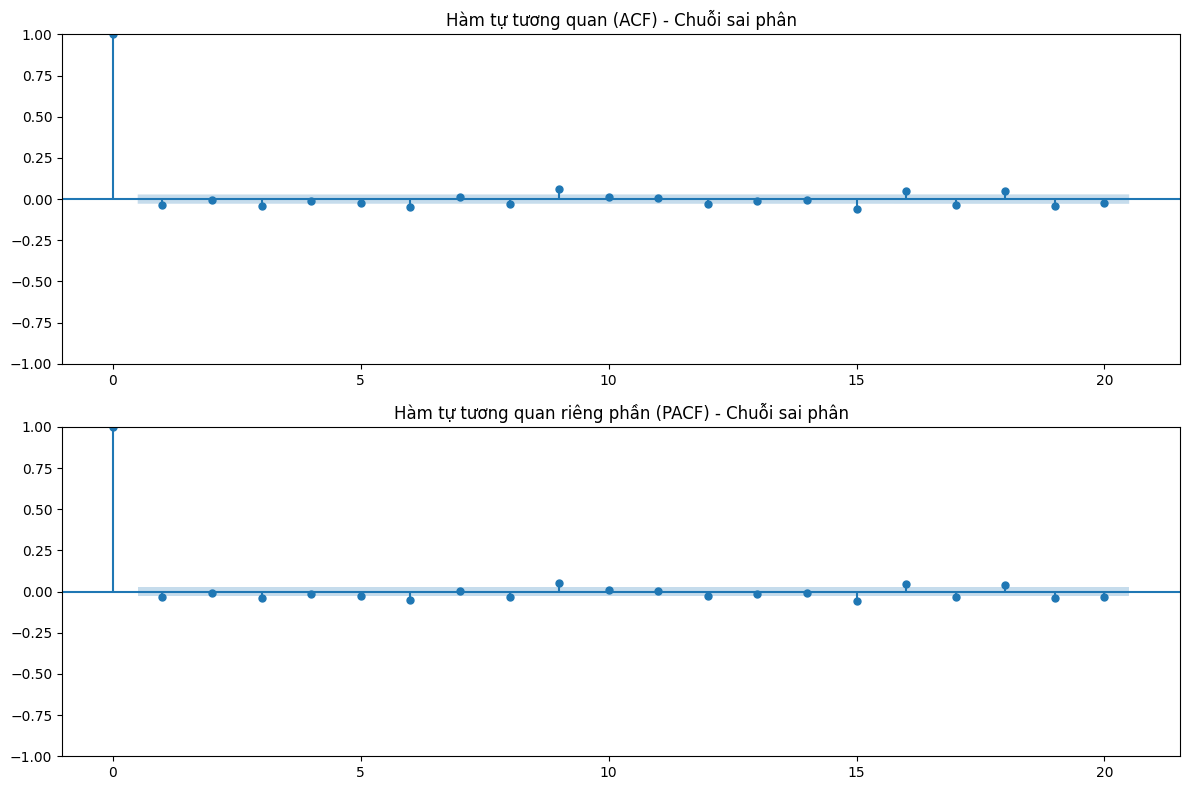

In [21]:
# 5. Vẽ ACF và PACF cho chuỗi sai phân
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plot_acf(diff_close, lags=20, ax=plt.gca())
plt.title('Hàm tự tương quan (ACF) - Chuỗi sai phân')

plt.subplot(2, 1, 2)
plot_pacf(diff_close, lags=20, ax=plt.gca())
plt.title('Hàm tự tương quan riêng phần (PACF) - Chuỗi sai phân')

plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4858
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -7153.978
Date:                Tue, 03 Jun 2025   AIC                          14311.957
Time:                        07:58:50   BIC                          14324.933
Sample:                             0   HQIC                         14316.512
                               - 4858                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0342      0.006     -5.285      0.000      -0.047      -0.022
sigma2         1.1140      0.007    158.952      0.000       1.100       1.128
Ljung-Box (L1) (Q):                   0.00   Jarque-

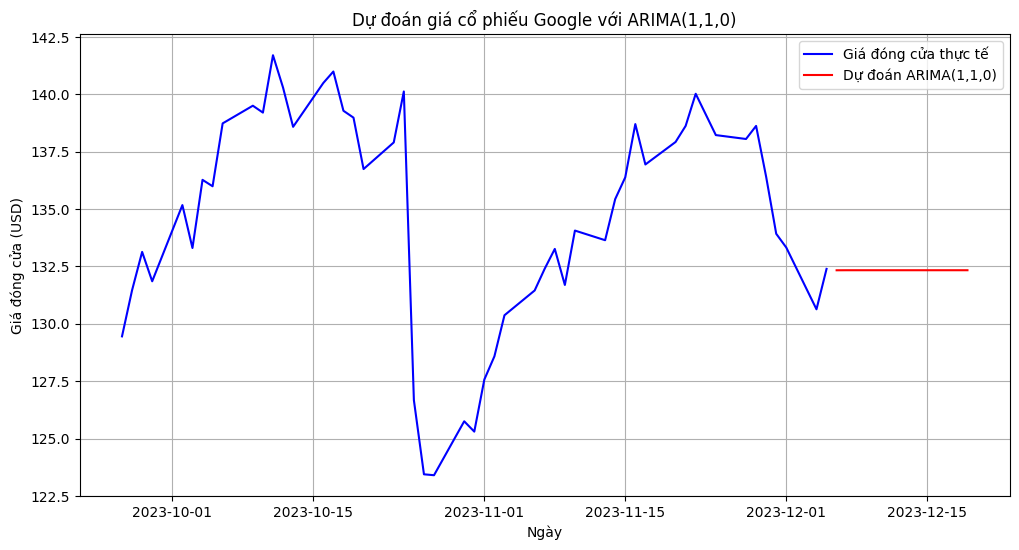

In [22]:
# 6. Khớp mô hình ARIMA(1,1,0) dựa trên PACF
model = ARIMA(close_prices, order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

# Dự đoán 10 bước tiếp theo
forecast = model_fit.forecast(steps=10)
forecast_index = pd.date_range(start=close_prices.index[-1] + pd.Timedelta(days=1), periods=10, freq='B')

# Vẽ đồ thị dự đoán
plt.figure(figsize=(12, 6))
plt.plot(close_prices[-50:], label='Giá đóng cửa thực tế', color='blue')
plt.plot(forecast_index, forecast, label='Dự đoán ARIMA(1,1,0)', color='red')
plt.title('Dự đoán giá cổ phiếu Google với ARIMA(1,1,0)')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa (USD)')
plt.legend()
plt.grid(True)
plt.show()
